In [1]:
import numpy as np
import torch
from mpc_mpnet_planner import MPCMPNetPlanner
from matplotlib import pyplot as plt
from mpnet.sst_envs.utils import load_data, visualize_point, get_obs
import pickle
# from params.sst_step5_s1024_e32 import get_params
from params.sst_step5_s1024_e32_gr2 import get_params


In [2]:
env_id = 0
traj_id = 1
obs_list = get_obs('acrobot_obs', env_id)
data = load_data('acrobot_obs', env_id, traj_id)
ref_path = data['path']
start_goal = data['start_goal']
env_vox = torch.from_numpy(np.load('mpnet/sst_envs/acrobot_obs_env_vox.npy')[env_id]).unsqueeze(0).float()
final_goal = ref_path[-1]
final_start = ref_path[0]

params = get_params(final_goal)

In [13]:
params['mpc_verbose'] = True
print(params)# ## for params
# n_t = 5
# state_dim = 4
# control_dim = 1
# weights = np.ones(state_dim)*1
# weights[2:] = 0.2
# n_sample = 1024
# n_elite = 32
# t = 1e-1
# dt = 2e-2

# mu_t, sigma_t = 1e-1, 4e-1
# t_min, t_max = 0, 5e-1

# mu_u = np.zeros((n_t*control_dim))
# sigma_u_diag = np.ones(n_t*control_dim)
# sigma_u_diag[:] = 4
# sigma_u = np.diag(sigma_u_diag)
# params = {
#     'n_sample': n_sample,
#     'n_elite': n_elite,
#     'n_t': n_t,
#     'weights': weights,
#     'mu_u': mu_u,
#     'sigma_u': sigma_u,
#     't': t,
#     'dt': dt,

#     'mu_t': np.ones(n_t) * mu_t,
#     'sigma_t': np.identity(n_t)*sigma_t,
#     't_min': t_min,
#     't_max': t_max,

#     'state_dim': state_dim,
#     'control_dim': control_dim,
#     'converge_radius': 1e-1,
#     'drop_radius': 5,
#     'goal_radius': 10, #np.sqrt(2),
#     'max_it': 5,
#     'rolling_count': n_t,
#     'bk_it': 2,
#     'final_goal': ref_path[-1],
#     'mpc_mode': 'solve',#'mpc_mode': 'rolling'
#     'max_plan_it': 300,
    
    
# #     'planning_mode': 'line_search',
#     'planning_mode': 'tree',
#     'delta_near': 10,
#     'delta_drain': 1e-3,
# #     'tree_sample': False,
#     'tree_sample': True
# }
params['mpc_verbose'] = True
params['delta_drain'] = 1
print(params)

{'n_sample': 1024, 'n_elite': 32, 'n_t': 5, 'weights': array([1. , 1. , 0.2, 0.2]), 'mu_u': array([0., 0., 0., 0., 0.]), 'sigma_u': array([[4., 0., 0., 0., 0.],
       [0., 4., 0., 0., 0.],
       [0., 0., 4., 0., 0.],
       [0., 0., 0., 4., 0.],
       [0., 0., 0., 0., 4.]]), 't': 0.1, 'dt': 0.02, 'mu_t': array([0.1, 0.1, 0.1, 0.1, 0.1]), 'sigma_t': array([[0.4, 0. , 0. , 0. , 0. ],
       [0. , 0.4, 0. , 0. , 0. ],
       [0. , 0. , 0.4, 0. , 0. ],
       [0. , 0. , 0. , 0.4, 0. ],
       [0. , 0. , 0. , 0. , 0.4]]), 't_min': 0, 't_max': 0.5, 'mpc_verbose': True, 'state_dim': 4, 'control_dim': 1, 'converge_radius': 0.1, 'drop_radius': 10, 'goal_radius': 2, 'max_it': 5, 'rolling_count': 5, 'bk_it': 2, 'final_goal': array([ 2.32865188,  0.73296797,  0.16116229, -1.7614149 ]), 'mpc_mode': 'solve', 'max_plan_it': 500, 'planning_mode': 'tree', 'delta_near': 5, 'delta_drain': 0.1, 'tree_sample': True}
{'n_sample': 1024, 'n_elite': 32, 'n_t': 5, 'weights': array([1. , 1. , 0.2, 0.2]), 'mu_

In [14]:
import sys
sys.path.append('/media/arclabdl1/HD1/Linjun/mpc-mpnet-py/deps/sparse_rrt-1')
from sparse_rrt import _sst_module
class AcrobotDistance(_sst_module.IDistance):
    '''
    Custom distance function for acrobot in python (reimplementation of cpp distance function)
    '''
    def angular_error(self, state, goal):
        error = np.abs(state - goal)
        if error > np.pi:
            error = np.pi * 2 - error
        return error
    
    def distance(self, state, goal):
        return self.angular_error(state[0], goal[0]) * params['weights'][0] +\
            self.angular_error(state[1], goal[1]) * params['weights'][1] + \
            (state[2] - goal[2]) ** 2 * params['weights'][2] +\
            (state[3] - goal[3]) ** 2 * params['weights'][2]

In [15]:
%%time
mpc_mpnet = MPCMPNetPlanner(params,
                            #start_goal[0], 
                            #start_goal[1],
                            final_start,
                            final_goal,
                            env_vox,
                            system="acrobot_obs",
                            setup="default_norm",
                            #setup="default_norm_aug",
#                             setup="norm_nodiff_noaug_20step2e-2",
                            ep=5000,
                            obs_list=obs_list[env_id], verbose=True,
                            #distance_func=AcrobotDistance()
                           )
mpc_mpnet.mpnet.train()
# mpc_mpnet.mpnet.eval()
mpc_mpnet.reset_sst_backend()

it = 0

# max_it = params['max_plan_it']
max_it = 100
while it < max_it and not mpc_mpnet.reached:
    mpc_mpnet.reset()
    for i in range(20):
        print('iteration:{}, it:{}'.format(i, it))
        mpc_mpnet.step()
        if mpc_mpnet.reached:
            break
        it += 1

print(sum(mpc_mpnet.costs),'ref:', sum(data['cost']))
# mpc_mpnet.params['tree_sample'] = True
# while it < 100 and not mpc_mpnet.reached:
# #     mpc_mpnet.reset()
#     print('iteration:{}, it:{}'.format(i, it))
#     mpc_mpnet.step()
#     if mpc_mpnet.reached:
#         break
#     it += 1

iteration:0, it:0
0.48246382305963575 inf
converged at  3
loss: [0.03481027]
[74.64991058]
iteration:1, it:1
0.06679535810208681 inf
converged at  0
loss: [0.06679536]
[74.64991058]
iteration:2, it:2
0.1480165399230571 inf
converged at  1
loss: [0.042597]
[74.06430377]
iteration:3, it:3
0.41318351047656765 inf
0.41318351047656765 0.41318351047656765
0.41318351047656765 0.41318351047656765
0.41318351047656765 0.41318351047656765
0.41318351047656765 0.41318351047656765
0.41318351047656765 0.41318351047656765
loss: [0.41318351]
[74.64991058]
iteration:4, it:4
0.46578812012086396 inf
0.46578812012086396 0.46578812012086396
0.46578812012086396 0.46578812012086396
0.46578812012086396 0.46578812012086396
0.46578812012086396 0.46578812012086396
0.46578812012086396 0.46578812012086396
loss: [0.46578812]
[74.64991058]
iteration:5, it:5
0.3756960814070755 inf
0.2752322649238739 0.3756960814070755
0.28629905310944265 0.2752322649238739
0.2880688650522244 0.2752322649238739
0.28486321827816286 0.27

In [16]:
mpc_mpnet.tree_backend.get_solution()

(array([[ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.24650288, -0.54286923,  0.86074763, -2.03307958],
        [ 0.35507425, -0.81566612,  0.62529964, -1.77608761],
        [-0.44126325,  2.38209705,  2.79336113, -0.57866216],
        [-0.02647673,  2.23695085,  3.05793308, -1.56180221],
        [-0.28385746, -1.7511499 , -1.24947746, -0.15098292],
        [ 0.98112992,  2.53489342,  0.75909466, -1.94579933],
        [-1.46422781, -2.18761607, -1.5712381 ,  2.0371097 ],
        [-1.6227211 , -1.91916539, -0.12661138,  0.89031282],
        [ 2.32373437,  1.00916749,  1.01445448, -2.09244536],
        [ 2.48146501,  0.44563743,  0.07826575, -1.81710101]]),
 array([[4.68353357e-310],
        [4.68358117e-310],
        [4.68358375e-310],
        [4.68358384e-310],
        [4.68358299e-310],
        [4.68358342e-310],
        [4.68358338e-310],
        [4.68358315e-310],
        [4.68358299e-310],
        [4.68358322e-310]]),
 array([0.44826867, 0.64195412, 1.41944154, 

<IPython.core.display.Javascript object>


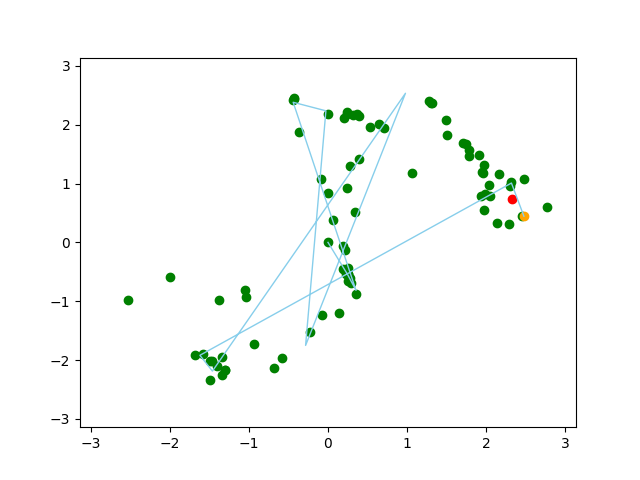

[[ 2.48146501  0.44563743  0.07826575 -1.81710101]] [[ 2.32865188  0.73296797  0.16116229 -1.7614149 ]]


In [17]:
%matplotlib notebook

# if mpc_mpnet.reached:
path = np.array(mpc_mpnet.path)
plt.plot(path[:,0], path[:,1], color='skyblue', linewidth=1)
plt.scatter(ref_path[0,0], ref_path[0,1], color='green')

samples = np.array(mpc_mpnet.samples)
plt.scatter(samples[:,0], samples[:,1], color='green')
plt.scatter(mpc_mpnet.state[:,0], mpc_mpnet.state[:,1], color='orange')
plt.scatter(ref_path[-1,0], ref_path[-1,1], color='red')
plt.xlim(-np.pi, np.pi)
plt.ylim(-np.pi, np.pi)
print(mpc_mpnet.state, mpc_mpnet.goal)

In [18]:
# %matplotlib notebook
# samples = np.array(mpc_mpnet.samples)
# plt.plot(samples[:,0], samples[:,1], color='green')
# plt.scatter(ref_path[0,1], ref_path[0,1], color='orange')
# plt.scatter(ref_path[-1,1], ref_path[-1,1], color='red')

<IPython.core.display.Javascript object>


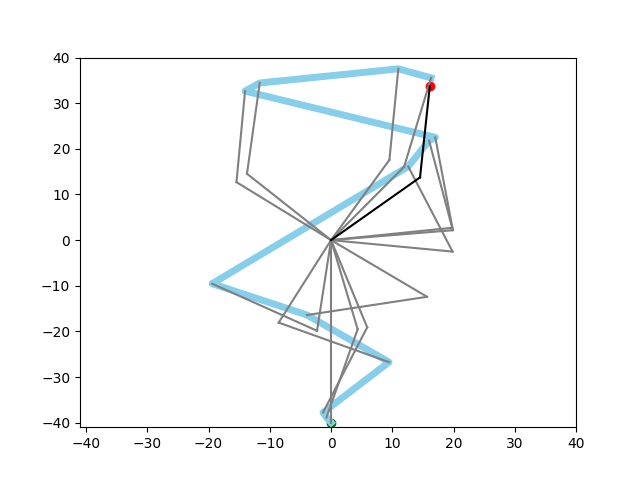

(-41.0, 40.0)

In [9]:
%matplotlib notebook

endeff = []#[[0, -40]]
node1 = []#[[0, -20]]
for p in path:
    ex1, ey1, ex2, ey2 = visualize_point(p)
    endeff.append([ex2, ey2])
    node1.append([ex1, ey1])

endeff = np.array(endeff)
node1 = np.array(node1)
x1, y1, x2, y2 = visualize_point(ref_path[-1])


plt.plot(endeff[:,0], endeff[:,1], color='skyblue', linewidth=5)
plt.scatter(endeff[:,0], endeff[:,1], color='blue', s=1)

for i in range(endeff.shape[0]):
    plt.plot([0, node1[i,0]], [0, node1[i,1]], color='gray')
    plt.plot([node1[i,0], endeff[i,0]], [node1[i,1], endeff[i,1]], color='gray')
plt.plot([0, x1], [0, y1], color='black')
plt.plot([x1, x2], [y1, y2], color='black')
    
plt.scatter(endeff[0, 0], endeff[0, 1], color='green')
plt.scatter(x2, y2, color='red')
plt.xlim(-41, 40)
plt.ylim(-41, 40)


In [9]:
point1=[-1.70913442, -2.11900729, -1.490959    ,1.78293082]
point2=start_goal[-1]
LENGTH=20
M_PI = np.pi
STATE_THETA_1, STATE_THETA_2 = [0, 1]
x=(LENGTH) * np.cos(point1[STATE_THETA_1] - M_PI / 2)+(LENGTH) * np.cos(point1[STATE_THETA_1] + point1[STATE_THETA_2] - M_PI / 2);
y = (LENGTH) * np.sin(point1[STATE_THETA_1] - M_PI / 2)+(LENGTH) * np.sin(point1[STATE_THETA_1] + point1[STATE_THETA_2] - M_PI / 2);
x2 = (LENGTH) * np.cos(point2[STATE_THETA_1] - M_PI / 2)+(LENGTH) * np.cos(point2[STATE_THETA_1] + point2[STATE_THETA_2] - M_PI / 2);
y2 = (LENGTH) * np.sin(point2[STATE_THETA_1] - M_PI / 2)+(LENGTH) * np.sin(point2[STATE_THETA_1] + point2[STATE_THETA_2] - M_PI / 2);
print(x,y,x2,y2,np.sqrt(pow(x-x2,2.0)+pow(y-y2,2.0)))


state =np.array([[-1.70913442, -2.11900729, -1.490959    ,1.78293082]])
goal = start_goal[-1]
LENGTH = 20.
x = LENGTH*(np.cos(state[:, 0] - np.pi / 2)+np.cos(state[:, 0] + state[:, 1] - np.pi / 2))
y = LENGTH*(np.sin(state[:, 0] - np.pi / 2)+np.sin(state[:, 0] + state[:, 1] - np.pi / 2))
x2 = LENGTH*(np.cos(goal[0] - np.pi / 2)+np.cos(goal[0] + goal[1] - np.pi / 2))
y2 = LENGTH*(np.sin(goal[0] - np.pi / 2)+np.sin(goal[0] + goal[1] - np.pi / 2))
np.sqrt((x-x2)**2+(y-y2)**2)

-7.1314933109690095 18.22670696332539 -5.44144040758353 20.001035189684135 2.450412102299337


array([2.4504121])